# Reproduction: Improved StyleGAN Embedding: Where are the Good Latents?

In this notebook, I will reproduce the process of the paper [Improved StyleGAN Embedding: Where are the Good Latents?](https://arxiv.org/abs/2012.09036). Particulary, we will implement the new spaces $P$, $P_N$ and $P_N^+$

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!nvidia-smi

Wed Jun  2 18:44:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
%cd /content/gdrive/MyDrive/internship/style-gan/

/content/gdrive/MyDrive/internship/style-gan


In [4]:
!pip install click requests tqdm pyspng ninja imageio-ffmpeg==0.4.3
!pip install lpips
!pip install pytorch-ignite
!pip install pytorch-msssim

In [5]:
# Import the needed libraries
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import os
import IPython
from PIL import Image
import glob
from sklearn.decomposition import PCA
import numpy as np 
from torchvision.utils import save_image
from torchsummary import summary
from torchvision import models, transforms
from ignite.metrics import PSNR
from ignite.engine import Engine
from pytorch_msssim import ssim

import torch.optim as optim
import torch.nn.functional as F
import lpips
import dnnlib
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Setting global attributes
RESOLUTION = 1024
#DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ITERATIONS = 1300
SAVE_STEP = 100

# OPTIMIZER
LEARNING_RATE = 0.01
BETA_1 = 0.9
BETA_2 = 0.999
EPSILON = 1e-8
regularizer_lambda = 0.001

# IMAGE TO EMBED
#PATH_IMAGE = "stuff/data/expression02.png"
PATH_DIR = "stuff/data/input/"
EXPECTED_RESULTS = "stuff/data/Peihao_result/"
SAVING_DIR = 'stuff/results/improved_embedding_v3/'
PCA_DIR = "stuff/data/pca/"


In [7]:
DEVICE

device(type='cuda', index=0)

## Loadding Pretrained Model
Load the pretrained model using the pickle file. I need the libraries `dnnlib` and `torch_utils` to load this model.

It does not need source code for the networks themselves — their class definitions are loaded from the pickle via `torch_utils.persistence`.


In [8]:
PRETRAINED_MODEL = "stuff/pretrained_models/ffhq.pkl"

with open(PRETRAINED_MODEL, 'rb') as f:
    G = pickle.load(f)['G_ema'].to(DEVICE)  # torch.nn.Module-
    G.mapping.num_ws = 1 # setting to the space w not w+ that was defined by deafault

The pickle contains three networks. `'G'` and `'D'` are instantaneous snapshots taken during training, and `'G_ema'` represents a moving average of the generator weights over several training steps. The networks are regular instances of `torch.nn.Module`, with all of their parameters and buffers placed on the CPU at import and gradient computation disabled by default.

The generator consists of two submodules, `G.mapping` and `G.synthesis`, that can be executed separately. They also support various additional options:

```.python
w = G.mapping(z, c, truncation_psi=0.5, truncation_cutoff=8)
img = G.synthesis(w, noise_mode='const', force_fp32=True)
```

Please refer to [`generate.py`](./generate.py), [`style_mixing.py`](https://github.com/NVlabs/stylegan2-ada-pytorch/blob/main/style_mixing.py), and [`projector.py`](./projector.py) for further examples.

From G we need to extract the `mapping` and the `synthesis` modules.

## $P$ Space

The authors transformed  the $W$ space  to  the $P$ space  by inverting the last Leaky ReLU layer in the StyleGAN mapping network.

Since the last Leaky ReLU uses a slope of $0.2$. They, invert it using

$$x= LeakyReLU_{5.0}(w)$$ 

where $w$ and $x$ are latents in $W$ and $P$ space respectively.

In [9]:
class mapping_P(nn.Module):
  def __init__(self):
    super(mapping_P, self).__init__()
    self.leakyRELU = nn.LeakyReLU(negative_slope=5.0)

  def forward(self, input):
    result = G.mapping(input, None) # TODO: check what happend with truncation?
    result = self.leakyRELU(result)
    return result.squeeze(1)

In [10]:
z = torch.randn((1, 512), device=DEVICE)
z.size()

torch.Size([1, 512])

In [11]:
print(G.mapping.w_dim)

512


In [12]:
print(G.mapping.num_ws)

1


In [13]:
x = mapping_P()(z) # tensor in the P space
print(x.size()) 

Setting up PyTorch plugin "bias_act_plugin"... Done.
torch.Size([1, 512])


## $P_N$ Space

The following step is to produce the $P_N$ from $P$. The authors aimed with this
  1. eliminate the dependency among latent variables;
  2. remove redundancy and only capture the major information of the latent distribution.
  
Thus, they define an affine transformation from $P$ to $P_N$ space as:

$$\hat{v}=\Lambda^{−1}·C^T(x−\mu)$$ 

where $\Lambda^{−1}$ is a scaling matrix, $C$ is an orthogonal matrix and $\mu$ is a mean vector. They are estimated by applying Principal  Component  Analysis (PCA)  to $X \in \mathbb{R}^{10^6\times512}$ consisting of 1 million latent samples in $P$ space.

In this regard, the steps to get the values in the new $P_N$ space are the following:

1. Sampling of $10^6$ in $Z$ space.
2. Mapping the samples to $W$ space.
3. Mapping the samples to $P$ space, getting $X \in \mathbb{R}^{10^6\times512}$
3. Apply PCA over $X$
  $$C, \Lambda, \mu = PCA(X) $$
The rows of $C$ are the principal component axes; $\mu$ is the mean vector of $X$; and $\Lambda$ is a matrix containing the corresponding eigenvalues of $C$.
4. Apply the affine transformation over one sample $x$

$$\hat{v}=\Lambda^{−1}·C^T(x−\mu)$$ 


In [14]:
def generate_samples(num_samples):
  # 1. Sampling 10e6 in Z space # what is the interval of z?
  X = torch.randn((int(num_samples), 512), device=DEVICE)
  print("z: ", X.size())

  # 2. Mapping the samples to W space and then to P space
  # We have to perform the mapping by batches due to the RAM resources
  X = mapping_P()(X)
  print("X: ", X.size())

  return X

In [15]:
def apply_PCA(samples, q = 512):
  n_samples, n_features = samples.size()

  # get the 511 principal components
  U,S,V = torch.pca_lowrank(samples, q=q, center=True, niter=15)

  mean_vector = torch.mean(samples, dim=0)
  print("mean vector: ", mean_vector.size())

  eigen_values = (S**2)/(n_samples - 1)
  print("eigenvalues: ", eigen_values.size())

  print("eigenvectors: ", V.size())
  return V, eigen_values, mean_vector, S

In [16]:
def get_PCA_results(q = 512, save = False, load = False):

  file_name = os.path.join(PCA_DIR,f"pca_results_q_{q}.npz")

  # Apply PCA
  if load:
    print("Loading: ", file_name)
    data = np.load(file_name)
    C = torch.tensor(data['eigen_vectors']).to(DEVICE)
    E = torch.tensor(data['eigen_values']).to(DEVICE)
    mean = torch.tensor(data['mean']).to(DEVICE)
    S = torch.tensor(data['singulars']).to(DEVICE)

  else:
    # q are the used principal component
    X = generate_samples(1e6)
    C, E, mean, S = apply_PCA(X, q = q)

  if save:
    print("Saving: ", file_name)
    np.savez(file_name, eigen_vectors =C.cpu().numpy(), 
                        eigen_values =E.cpu().numpy(),
                        mean = mean.cpu().numpy(),
                        singulars = S.cpu().numpy())

  return C, E, mean, S

In [17]:
#Here we just load some previous tensor that where previously measured
C, E, mean, S = get_PCA_results(load = True)

Loading:  stuff/data/pca/pca_results_q_512.npz


In [18]:
# S = torch.sqrt((E * (1e6 - 1)))
Sinv = 1 / S

In [19]:
Einv = 1 / E

In [20]:
# checking max a min value
print("C -- max: {} min: {}".format(torch.max(C), torch.min(C)))
print("E -- max: {} min: {}".format(torch.max(E), torch.min(E)))
print("mean -- max: {} min: {}".format(torch.max(mean), torch.min(mean)))
print("Einv -- max: {} min: {}".format(torch.max(Einv), torch.min(Einv)))
print("S -- max: {} min: {}".format(torch.max(S), torch.min(S)))
print("Sinv -- max: {} min: {}".format(torch.max(Sinv), torch.min(Sinv)))

C -- max: 0.19690442085266113 min: -0.21129626035690308
E -- max: 29.946529388427734 min: 6.552676978799354e-08
mean -- max: 0.7678494453430176 min: -1.127732753753662
Einv -- max: 15260938.0 min: 0.03339285030961037
S -- max: 5472.33935546875 min: 0.25598183274269104
Sinv -- max: 3.906527280807495 min: 0.00018273720343131572


In [21]:
# checking the gradients and device of these three components
print("C: ", C.size(), C.requires_grad, C.device)
print("E: ", E.size(), E.requires_grad, E.device)
print("mean: ", mean.size(), mean.requires_grad, mean.device)


C:  torch.Size([512, 512]) False cuda:0
E:  torch.Size([512]) False cuda:0
mean:  torch.Size([512]) False cuda:0


## Define a module that will transform a $W^+$ latent to $P_N^+$ latent

Apply the affine transformation over one sample $x$

$$\hat{v}=\Lambda^{−1}·C^T(x−\mu)$$ 

Apply the affine transformation an concatenate 18 latents per resolution in generator. This allow us to get th $P_N^+$ space.

$$\mathbf{w}^{+}=\left\{\mathbf{w}_{i}\right\}_{i=1}^{18}$$

$$\mathbf{v}=\left\{\Lambda^{-1} \mathbf{C}^{T}\left(\mathbf{x}_{i}-\boldsymbol{\mu}\right)\right\}_{i=1}^{18}$$

In [22]:
class mapping_P_N(nn.Module):
    def __init__(self, C, E, mean):
        super(mapping_P_N, self).__init__()
        self.C = C
        self.leakyRELU = nn.LeakyReLU(negative_slope=5.0)
        self.E = E
        self.mean = mean.unsqueeze(0)

    def forward(self,input):
      """ the input must be the w+ vector """
      # transform to P space
      result = self.leakyRELU(input.squeeze(0))
          
      # rest the mean
      result = (result - self.mean).T

      # transform to PN space
      # result =  torch.matmul(torch.matmul( torch.diag(1/self.E), self.C.T), result)
      result =  torch.matmul(torch.diag(1/self.E), torch.matmul(self.C.T, result))

      return result.T


In [23]:
#check the affine transformation
w_plus = torch.zeros((1,18,512),requires_grad=True,device=DEVICE)
map_f = mapping_P_N(C, S, mean)
p_n_plus = map_f(w_plus)
torch.linalg.norm(p_n_plus) ** 2

tensor(0.1035, device='cuda:0', grad_fn=<PowBackward0>)

## Loss Function

The embedding algorithm selects a random initial latent code and optimize it using gradient descent. To do that, the authors defines a loss function based on LPIPS perceptual loss and the pixel-wise MSE loss:

$$ w^{*}=\min _{w} L_{\text {percept }}(G(w), I)+\frac{\lambda_{m s e}}{N}\|G(w)-I\|_{2}^{2} $$

### LPIPS perceptual loss

In this reproduction, I propose to use another perceptual loss, which has demonstrated a better performance in term of perceptual metrics according to the following article [The Unreasonable Effectiveness of Deep Features as a Perceptual Metric](https://arxiv.org/abs/1801.03924). The metric was named **Learned Perceptual Image Patch Similarity**(LPIPS). 

This metric measure a distance between a reference and synthetic image using the intermediate activated feature maps of a common network $\mathcal{F}$. However, in this case the authors following the next steps:

1. Extract  feature  stack  from $L$ layers 
2. Unit-normalize  in the  channel  dimension, designated as $\hat{y}^l, \hat{y}^l_0 \in \mathbb{R}^{H_l \times W_l \times Cl} $ for layer $l$. 
3. Scale the activations channel-wise by vector $w_l \in \mathbb{R}^{C_l}$
4. Compute the $l2$ distance.
5. Finally average spatially and sum channel-wise. 

The previous process leave us to

$$ d\left(x, x_{0}\right)=\sum_{l} \frac{1}{H_{l} W_{l}} \sum_{h, w}\left\|w_{l} \odot\left(\hat{y}_{h w}^{l}-\hat{y}_{0 h w}^{l}\right)\right\|_{2}^{2} $$

Note: Additionally this perceptual metric could be using patches of the reference and synthesis images, instead of the completed image.


In [24]:
# Pixel-Wise MSE Loss
MSE_Loss = nn.MSELoss(reduction="mean")

# Load VGG16 feature detector. # StyleGANv2 version of metric
perceptual_vgg16 = lpips.LPIPS(net='vgg',version='0.0').to(DEVICE)

# affine transformation to P_N+
affine_PN = mapping_P_N(C, S, mean)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.0], spatial [off]
Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.0/vgg.pth


NOTE: The authors proposes to use bicubic  downsampling  on  the  generated  images  and  Lanczos downsampling on the reference image. But here it is not prove.

## Embedding Latent and Optimizer Adam

In the article, the authors mention that they select a random initial latent code and optimize it using gradient descent. In this way, I define our tensor `embedding_latent` with gradients.

The paper also mentions that this embedding_latent can be initialized of different ways. Here, we have three options:

1. w+ all to zero 
2. w+ $\sim \mathcal{U}[-1,1]$ (random)
3. w+ $ = \bar{w}$ (the meant latent vector)

Then, I define the adam optimizer with the specification of the paper.

In [25]:
n_samples = 5e5
def get_mean_latent():
  z = torch.randn((int(n_samples), 512), device=DEVICE)
  batch_size = int(1e5)

  w_mean = torch.zeros((1,18,512),requires_grad=True,device=DEVICE)
  for i in range(int(n_samples/batch_size)):
    
    w = G.mapping(z[i*batch_size:(i+1)*batch_size,:], None)
    w = torch.sum(w, dim = 0).unsqueeze(0)
    w_mean = w_mean + w

  w_mean = w_mean / n_samples

  return w_mean.clone().detach().requires_grad_(True)

## Preparing Data

Should I peform any preproccesing to the the images according to the paper? Here, I checked the reference image and the first synthetic image.

In [26]:
#@title Function to load data from a folder
def load_data(directory, interval = None):

  if interval is None:
    files = sorted(glob.glob(os.path.join(directory + "*.png")))
  else:
    files = sorted(np.array(glob.glob(os.path.join(directory + "*.png")))[interval])

  data = {}
  for idx, file in enumerate(files):
    img_dir = {
        # "img": lpips.load_image(file),
        "img": Image.open(file),
        "name": os.path.basename(os.path.normpath(file))
    }
    data[idx] = img_dir
  return data

In [27]:
#@title Function to display the data
def display_data(data, ncols=4):

    inches = 4
    num_img = len(data)
    nrows = np.ceil(num_img/ncols).astype(int)
    fig, axs = plt.subplots(nrows,ncols,figsize=(inches * ncols , inches * nrows))

    idx = 0
    for i in range(nrows):
      for j in range(ncols):
        if idx < num_img:
          axs[i,j].imshow(data[idx]['img'])
          axs[i,j].set_title("Image ID: {}".format(idx))
          axs[i,j].axis('off')
          idx += 1


In [28]:
data = load_data(PATH_DIR, np.r_[0:12])
# data = load_data(PATH_DIR, np.r_[0:12])

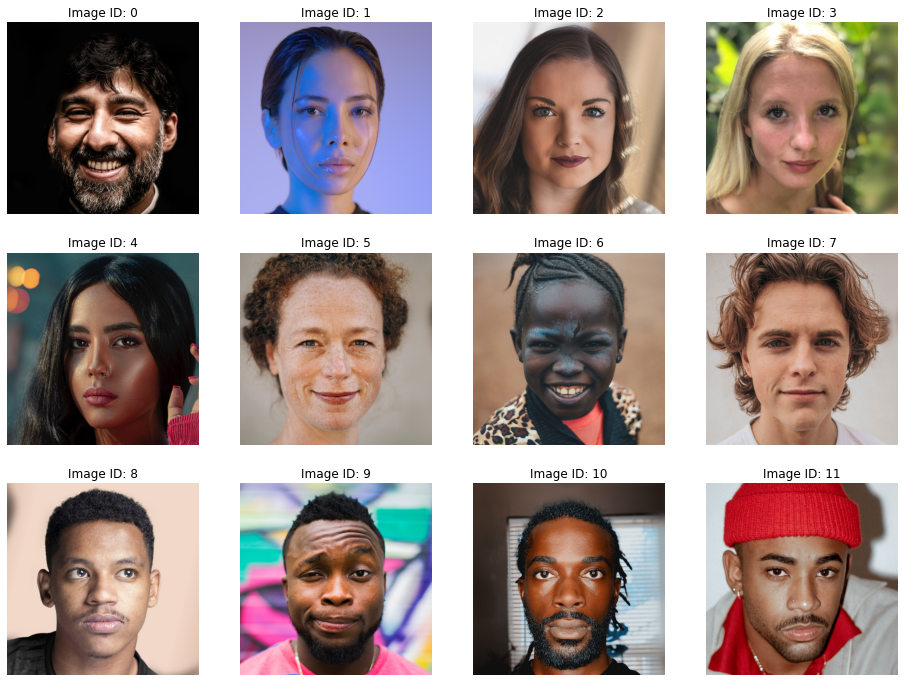

In [29]:
display_data(data)

Now we define our loss functions, and the function that will measure the loss. In this function, according to the new paper, we have to define the regulizer based on the `p_n_plus` latent space

In [30]:
def to_tensor(input_img):
  transform = transforms.Compose([
    transforms.ToTensor()                          
  ])

  return transform(input_img).unsqueeze(0).to(DEVICE)

def lanczos_transform(input_img):
  transform = transforms.Compose([
    transforms.Resize(
        256,
        interpolation = transforms.functional.InterpolationMode.LANCZOS
    ),
    transforms.ToTensor()
  ])
  return transform(input_img).to(DEVICE)

def normalize_input(input_img):
  transform = transforms.Compose([
  transforms.Normalize(
      mean=[0.485, 0.456, 0.406],
      std=[0.229, 0.224, 0.225],
  ),
])
  return transform(input_img)

In [49]:
def calculate_loss(synth_img, reference_img, w_opt, perceptual_net, MSE_Loss, affine_PN, downsampling_mode = 'bicubic', lambda_v = 0.001):
  """ This calculate the mse loss, perceptual loss and the regulizer term

  syth_img [tensor] : generated image in a tensor [1,3,1024,1024] with normalization [-1,1]
  reference_img [tensor] : reference image in a tensor [1,3,1024, 1023] with normalization [0,1]
  w_opt [tensor] : latent code to be optimized in a tensor [1,18,512]
  perceptual_net [nn.Module] : perceptual net used to measure the percetual loss
  MSE_Loss [nn.Module]: mse loss function used to measure the mse loss
  affine_PN [nn.Module]: modulo to transform from w+ to PN+
  downsampling_mode[str] (optional) : downsampling method used during the resizing of reference and synthetic images.
  lambda_v[float] (optional) : lambda used to adjust the regularizer.

  """
  # change to the range [0,1]
  synth_img = (synth_img + 1) / 2

  # Downsampling
  tmp_synth_img = F.interpolate(synth_img, size=(256, 256), mode=downsampling_mode)
  tmp_refer_img = F.interpolate(reference_img, size=(256, 256), mode=downsampling_mode)

  # Normalize with mean and std
  tmp_synth_img = normalize_input(tmp_synth_img)
  tmp_reference_img = normalize_input(tmp_refer_img)

  # calculate LPIPS Perceptual Loss
  # Features for synth images.
  perceptual_loss = perceptual_net.forward(tmp_reference_img, tmp_synth_img)


  # normalize to [-1,1] to measure the MSE loss
  reference_img = 2*reference_img - 1
  synth_img = 2*synth_img - 1
  # calculate MSE Loss
  mse_loss = MSE_Loss(synth_img,reference_img) 

  
  # adding the regulizer part
  regularizer = lambda_v * (torch.linalg.norm(affine_PN(w_opt)) ** 2)

  return mse_loss, perceptual_loss, regularizer

## Embedding one image


In this process, we try to adjust the embedding_latent in such a way that the synthetic image is the same as the original image. To do that, we follow the net steps: 

1. Feed the pretrained generator with the embedding latent and get the synthetic image
2. Calculate the loss between the synthetic image and the original image
2. Backward the gradients and apply the optimization

Note: additionally we save the generated image, and the current embedding_latent every 100 steps

In [50]:
def run_optimization(data, id, init, sub_fix ="", 
                     downsampling_mode = 'bicubic', 
                     save_loss = False, 
                     lambda_v = 0.001):


  # get the image sample
  basename = data[id]['name'].split(".")[0] + sub_fix
  reference_img = to_tensor(data[id]['img'])
  
  # define the init latent
  if init == "w_mean":
    w_opt = get_mean_latent()
  elif init == "w_zeros":
    w_opt = torch.zeros((1,18,512),requires_grad=True,device=DEVICE)
  elif init == "w_random":
    w_opt = torch.cuda.FloatTensor(1,18,512).uniform_(-1,1).requires_grad_()


  optimizer = optim.Adam({w_opt},lr=LEARNING_RATE,betas=(BETA_1,BETA_2),eps=EPSILON)

  print("Starting Embedding: id: {} name: {}".format(id,basename))
  loss_list=[]
  loss_mse=[]
  loss_perceptual=[]
  latent_list = {}
  for i in range(0,ITERATIONS):
      # reset the gradients
      optimizer.zero_grad()

      # get the synthetic image
      synth_img = G.synthesis(w_opt, noise_mode='const')
      
      # get the loss and backpropagate the gradients
      mse_loss, perceptual_loss, regularizer_term = calculate_loss(synth_img,
                                                reference_img,
                                                w_opt,
                                                perceptual_vgg16, 
                                                MSE_Loss, 
                                                affine_PN,
                                                downsampling_mode,
                                                lambda_v)                                                
      loss = mse_loss + perceptual_loss + regularizer_term
      loss.backward()

      optimizer.step()

      # store the losses metrics
      loss_list.append(loss.item())
      loss_mse.append(mse_loss.item())
      loss_perceptual.append(perceptual_loss.item())

      # every SAVE_STEP, I store the current latent
      if (i +1) % SAVE_STEP == 0:
          print('iter[%d]:\t loss: %.4f\t mse_loss: %.4f\tpercep_loss: %.4f\tregularizer: %.4f' % (i+1,  
                                                                                                   loss.item(), 
                                                                                                   mse_loss.item(), 
                                                                                                   perceptual_loss.item(),
                                                                                                   regularizer_term.item()))
          latent_list[str(i+1)] = w_opt.detach().cpu().numpy()

  # store all the embeddings create during optimization in .npz
  path_embedding_latent = os.path.join(SAVING_DIR, 
                                      "latents/{}_latents_iters_{}_step_{}_{}.npz".format(
                                        basename,
                                        str(ITERATIONS).zfill(6),
                                        str(SAVE_STEP).zfill(4), 
                                        init))
  print("Saving: {}".format(path_embedding_latent))
  np.savez(path_embedding_latent, **latent_list)

  if save_loss:
    loss_file = "loss_plots/{}_loss_iters_{}_step_{}_{}.npy".format(
                                        basename,
                                        str(ITERATIONS).zfill(6),
                                        str(SAVE_STEP).zfill(4), 
                                        init)
    path_loss = os.path.join(SAVING_DIR, loss_file)
    print("Saving Loss: {}".format(path_loss))
    np.save(path_loss, np.array(loss_list))
  return loss_list

## Experiments

In [51]:
# I fixed the max iteration
ITERATIONS = 2000

In [52]:
# testing downsampling
test_name = 'only_lanczos'
options_downsampling = ['area']
options_lambdas = [0.001, 0.005]

for mode in options_downsampling:
  for lambda_v in options_lambdas:
    loss_list = run_optimization(data, id = 3, 
                                init = 'w_mean', 
                                sub_fix=f"_{test_name}_{mode}_lambda_{lambda_v}",
                                save_loss = True, 
                                downsampling_mode=mode, 
                                lambda_v=lambda_v)

Starting Embedding: id: 3 name: alex-lee-l7oI8wCfQ8Y-unsplash_only_lanczos_area_lambda_0.001
iter[100]:	 loss: 0.1255	 mse_loss: 0.0437	percep_loss: 0.0812	regularizer: 0.0007
iter[200]:	 loss: 0.1011	 mse_loss: 0.0333	percep_loss: 0.0671	regularizer: 0.0008
iter[300]:	 loss: 0.0827	 mse_loss: 0.0253	percep_loss: 0.0564	regularizer: 0.0010
iter[400]:	 loss: 0.0696	 mse_loss: 0.0208	percep_loss: 0.0478	regularizer: 0.0010
iter[500]:	 loss: 0.0611	 mse_loss: 0.0182	percep_loss: 0.0418	regularizer: 0.0010
iter[600]:	 loss: 0.0569	 mse_loss: 0.0170	percep_loss: 0.0388	regularizer: 0.0011
iter[700]:	 loss: 0.0532	 mse_loss: 0.0158	percep_loss: 0.0363	regularizer: 0.0011
iter[800]:	 loss: 0.0507	 mse_loss: 0.0150	percep_loss: 0.0346	regularizer: 0.0012
iter[900]:	 loss: 0.0482	 mse_loss: 0.0142	percep_loss: 0.0329	regularizer: 0.0011
iter[1000]:	 loss: 0.0467	 mse_loss: 0.0137	percep_loss: 0.0318	regularizer: 0.0012
iter[1100]:	 loss: 0.0452	 mse_loss: 0.0132	percep_loss: 0.0309	regularizer:

In [ ]:
# testing downsampling
test_name = 'only_lanczos'
options_downsampling = ['bicubic', 'bilinear']
options_lambdas = [0.001, 0.005]

for i in range(len(data)):
  for mode in options_downsampling:
    for lambda_v in options_lambdas:
      loss_list = run_optimization(data, id = i, 
                                  init = 'w_mean', 
                                  sub_fix=f"_{test_name}_{mode}_lambda_{lambda_v}",
                                  save_loss = True, 
                                  downsampling_mode=mode, 
                                  lambda_v=lambda_v)

Starting Embedding: id: 0 name: aatik-tasneem-7omHUGhhmZ0-unsplash_only_lanczos_bicubic_lambda_0.001
iter[100]:	 loss: 0.1094	 mse_loss: 0.0454	percep_loss: 0.0631	regularizer: 0.0009
iter[200]:	 loss: 0.0899	 mse_loss: 0.0396	percep_loss: 0.0496	regularizer: 0.0006
iter[300]:	 loss: 0.0817	 mse_loss: 0.0369	percep_loss: 0.0442	regularizer: 0.0006
iter[400]:	 loss: 0.0763	 mse_loss: 0.0350	percep_loss: 0.0407	regularizer: 0.0006
iter[500]:	 loss: 0.0718	 mse_loss: 0.0334	percep_loss: 0.0377	regularizer: 0.0006
iter[600]:	 loss: 0.0674	 mse_loss: 0.0321	percep_loss: 0.0347	regularizer: 0.0006
iter[700]:	 loss: 0.0639	 mse_loss: 0.0307	percep_loss: 0.0325	regularizer: 0.0007
iter[800]:	 loss: 0.0612	 mse_loss: 0.0298	percep_loss: 0.0307	regularizer: 0.0007
iter[900]:	 loss: 0.0594	 mse_loss: 0.0292	percep_loss: 0.0294	regularizer: 0.0007
iter[1000]:	 loss: 0.0580	 mse_loss: 0.0288	percep_loss: 0.0285	regularizer: 0.0007
iter[1100]:	 loss: 0.0568	 mse_loss: 0.0284	percep_loss: 0.0277	regu

In [ ]:
# testing downsampling
test_name = 'only_embed'
options_downsampling = ['area', 'bicubic', 'bilinear']
options_lambdas = [0.001, 0.005]

for i in range(7,len(data)):
  for mode in options_downsampling:
    for lambda_v in options_lambdas:
      loss_list = run_optimization(data, id = i, 
                                  init = 'w_mean', 
                                  sub_fix=f"_{test_name}_{mode}_lambda_{lambda_v}",
                                  save_loss = True, 
                                  downsampling_mode=mode, 
                                  lambda_v=lambda_v)

Starting Embedding: id: 7 name: austin-wade-X6Uj51n5CE8-unsplash_only_embed_area_lambda_0.001
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
iter[100]:	 loss: 0.0921	 mse_loss: 0.0341	percep_loss: 0.0575	regularizer: 0.0005
iter[200]:	 loss: 0.0778	 mse_loss: 0.0289	percep_loss: 0.0484	regularizer: 0.0005
iter[300]:	 loss: 0.0686	 mse_loss: 0.0253	percep_loss: 0.0427	regularizer: 0.0006
iter[400]:	 loss: 0.0647	 mse_loss: 0.0239	percep_loss: 0.0400	regularizer: 0.0007
iter[500]:	 loss: 0.0593	 mse_loss: 0.0218	percep_loss: 0.0367	regularizer: 0.0007
iter[600]:	 loss: 0.0568	 mse_loss: 0.0209	percep_loss: 0.0352	regularizer: 0.0007
iter[700]:	 loss: 0.0545	 mse_loss: 0.0202	percep_loss: 0.0336	regularizer: 0.0007
iter[800]:	 loss: 0.0531	 mse_loss: 0.0197	percep_loss: 0.0326	regularizer: 0.0007
iter[900]:	 loss: 0.0515	 mse_loss: 0.0192	percep_loss: 0.0316	regularizer: 0.0008
iter[1000]:	 loss: 0.0504	 mse_loss: 0.0189	percep_loss: 0.0308	regularizer: 0.0008
iter[1100]:	 loss: 0.

In [ ]:
# VGG-16 perceptual lpips loss
loss_list = run_optimization(data, id = 1, init = 'w_mean', save_loss = True)

Starting Embedding: id: 1 name: aiony-haust-3TLl_97HNJo-unsplash
iter[100]:	 loss: 0.1948	 mse_loss: 0.0223	percep_loss: 0.1715	regularizer: 0.0010
iter[200]:	 loss: 0.1615	 mse_loss: 0.0178	percep_loss: 0.1428	regularizer: 0.0008
iter[300]:	 loss: 0.1451	 mse_loss: 0.0156	percep_loss: 0.1287	regularizer: 0.0009
iter[400]:	 loss: 0.1330	 mse_loss: 0.0138	percep_loss: 0.1183	regularizer: 0.0009
iter[500]:	 loss: 0.1232	 mse_loss: 0.0121	percep_loss: 0.1101	regularizer: 0.0010
iter[600]:	 loss: 0.1191	 mse_loss: 0.0108	percep_loss: 0.1071	regularizer: 0.0011
iter[700]:	 loss: 0.1090	 mse_loss: 0.0094	percep_loss: 0.0984	regularizer: 0.0012
iter[800]:	 loss: 0.1052	 mse_loss: 0.0088	percep_loss: 0.0951	regularizer: 0.0013
iter[900]:	 loss: 0.0986	 mse_loss: 0.0082	percep_loss: 0.0890	regularizer: 0.0013
iter[1000]:	 loss: 0.0946	 mse_loss: 0.0079	percep_loss: 0.0854	regularizer: 0.0014
iter[1100]:	 loss: 0.0914	 mse_loss: 0.0075	percep_loss: 0.0825	regularizer: 0.0014
iter[1200]:	 loss: 0

In [ ]:
# VGG-16 perceptual lpips loss
for i in range(6,len(data)):
  loss_alex_w_mean_norm = run_optimization(data, id = i, init = 'w_mean', save_loss = True)

Starting Embedding: id: 6 name: annie-spratt-ZyWN6N41JUc-unsplash
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
iter[100]:	 loss: 0.3964	 mse_loss: 0.0573	percep_loss: 0.3380	regularizer: 0.0011
iter[200]:	 loss: 0.3285	 mse_loss: 0.0481	percep_loss: 0.2790	regularizer: 0.0014
iter[300]:	 loss: 0.2945	 mse_loss: 0.0428	percep_loss: 0.2501	regularizer: 0.0016
iter[400]:	 loss: 0.2721	 mse_loss: 0.0394	percep_loss: 0.2310	regularizer: 0.0017
iter[500]:	 loss: 0.2516	 mse_loss: 0.0358	percep_loss: 0.2141	regularizer: 0.0018
iter[600]:	 loss: 0.2394	 mse_loss: 0.0337	percep_loss: 0.2039	regularizer: 0.0019
iter[700]:	 loss: 0.2392	 mse_loss: 0.0328	percep_loss: 0.2042	regularizer: 0.0022
iter[800]:	 loss: 0.2390	 mse_loss: 0.0344	percep_loss: 0.2024	regularizer: 0.0022
iter[900]:	 loss: 0.2106	 mse_loss: 0.0302	percep_loss: 0.1782	regularizer: 0.0022
iter[1000]:	 loss: 0.2055	 mse_loss: 0.0292	percep_loss: 0.1739	regularizer: 0.0023
iter[1100]:	 loss: 0.1977	 mse_loss: 0.0283	perce

In [ ]:
# VGG-16 perceptual lpips loss
for i in range(len(data)):
  loss_alex_w_mean_norm = run_optimization(data, id = i, init = 'w_mean', save_loss = True)

Starting Embedding: id: 0 name: aatik-tasneem-7omHUGhhmZ0-unsplash
iter[100]:	 loss: 0.3210	 mse_loss: 0.0545	percep_loss: 0.2653	regularizer: 0.0012
iter[200]:	 loss: 0.2525	 mse_loss: 0.0470	percep_loss: 0.2045	regularizer: 0.0010
iter[300]:	 loss: 0.2127	 mse_loss: 0.0415	percep_loss: 0.1701	regularizer: 0.0011
iter[400]:	 loss: 0.1942	 mse_loss: 0.0385	percep_loss: 0.1546	regularizer: 0.0010
iter[500]:	 loss: 0.1821	 mse_loss: 0.0369	percep_loss: 0.1441	regularizer: 0.0011
iter[600]:	 loss: 0.1732	 mse_loss: 0.0354	percep_loss: 0.1366	regularizer: 0.0011
iter[700]:	 loss: 0.1655	 mse_loss: 0.0340	percep_loss: 0.1304	regularizer: 0.0011
iter[800]:	 loss: 0.1578	 mse_loss: 0.0327	percep_loss: 0.1239	regularizer: 0.0012
iter[900]:	 loss: 0.1522	 mse_loss: 0.0316	percep_loss: 0.1194	regularizer: 0.0012
iter[1000]:	 loss: 0.1468	 mse_loss: 0.0309	percep_loss: 0.1147	regularizer: 0.0012
iter[1100]:	 loss: 0.1439	 mse_loss: 0.0304	percep_loss: 0.1123	regularizer: 0.0012
iter[1200]:	 loss:

In [34]:
#@title Function to load latents
# Function to load the latents from the saved .npz file
def load_latents(file_name, display_latents = False):
  latent_embeddings_saved = os.path.join(SAVING_DIR, "latents/"+file_name)

  dictionary = {}
  with open(latent_embeddings_saved, 'rb') as f:
      container = np.load(f)
      
      for iter, latent in container.items():
          dictionary[iter] = latent
          if display_latents:
            print("iter: {} -- latent_code shape: {}".format(iter,latent.shape))
            print(latent[0,0,-5:])
  return dictionary

In [35]:
#@title Function to plot loss

# Function to plot the loss per iteration
def plot_loss(losses, basename,  save = False):

  plt.figure()
  scale_factor = 5

  plt.title("Loss During Embedding")
  for label, loss_file in losses.items():
    loss = np.load(os.path.join(SAVING_DIR, "loss_plots/" + loss_file))
    plt.plot(loss,label=label)
  plt.xlabel("Optimization Steps")
  plt.ylabel("Loss")
  plt.legend()
  

  if save:
    file_dir = os.path.join(SAVING_DIR, "loss_plots/{}_losses_iters_{}.svg".format(basename, str(ITERATIONS).zfill(6)))
    print("Saving: {}".format(file_dir))
    plt.savefig(file_dir)
    
  plt.show()

In [36]:
#@title Function to plot the synthetic image per iterations

def show_images_results(data, id, latents_file, iterations_to_show, subfix = "", expected_result = False, save = False, save_last = False):

    latent_codes = load_latents(latents_file)
    base_names_list = latents_file.split(".")
    base_name = '.'.join(base_names_list[:-1])

    saved_iterations = list(latent_codes.keys())
    iterations_to_show_filter = [iter for iter in iterations_to_show if str(iter) in saved_iterations]

    n_images = len(iterations_to_show_filter) + 1
    inches = 4
    if expected_result: n_images += 1
    fig, axs = plt.subplots(1,n_images ,figsize=(inches * n_images , inches))

    # original image
    axs[0].imshow(data[id]['img'])
    axs[0].set_title('Original')
    axs[0].axis('off')

    # embeddings per iterations
    idx = 1
    for iter in iterations_to_show:
      latent = latent_codes.get(str(iter))

      if latent is not None:
        tensor_latent = torch.tensor(latent).to(DEVICE)
        synth_img = G.synthesis(tensor_latent, noise_mode='const')
        # max_img = torch.max(synth_img)
        # min_img = torch.min(synth_img)
        # synth_img = (synth_img - min_img) / (max_img - min_img)
        synth_img = (synth_img + 1) / 2
        
        if save_last and iter == iterations_to_show[-1]:
          print("Saving last image...")
          save_image(synth_img.clamp(0,1), os.path.join(SAVING_DIR,"images/last_generated/{}.png".format(base_name)))

        synth_img = synth_img.detach().to('cpu').squeeze(0).permute(1, 2, 0)       
        axs[idx].imshow(synth_img.clamp(0,1))
        axs[idx].set_title("Iteration: {}".format(str(iter)))
        axs[idx].axis('off')



        idx += 1
      else:
        print("Iteration {} is not stored in file".format(iter))

    # expected result
    if expected_result:
      with open(EXPECTED_RESULTS + data[id]['name'],"rb") as f:
          image=Image.open(f)
          axs[idx].imshow(image)
          axs[idx].set_title('Expected Result')
          axs[idx].axis('off')

    if save:
      file_dir = os.path.join(SAVING_DIR, "images/{}{}.svg".format(
          base_name,
          subfix))
      print("Saving: {}".format(file_dir))
      plt.savefig(file_dir)

            

In [39]:
!ls $SAVING_DIR/loss_plots

aatik-tasneem-7omHUGhhmZ0-unsplash_loss_iters_001300_step_0100_w_mean.npy
aatik-tasneem-7omHUGhhmZ0-unsplash_only_embed_area_lambda_0.001_loss_iters_001300_step_0100_w_mean.npy
aatik-tasneem-7omHUGhhmZ0-unsplash_only_embed_area_lambda_0.005_loss_iters_001300_step_0100_w_mean.npy
aatik-tasneem-7omHUGhhmZ0-unsplash_only_embed_bicubic_lambda_0.001_loss_iters_001300_step_0100_w_mean.npy
aatik-tasneem-7omHUGhhmZ0-unsplash_only_embed_bicubic_lambda_0.005_loss_iters_001300_step_0100_w_mean.npy
aatik-tasneem-7omHUGhhmZ0-unsplash_only_embed_bilinear_lambda_0.001_loss_iters_001300_step_0100_w_mean.npy
aatik-tasneem-7omHUGhhmZ0-unsplash_only_embed_bilinear_lambda_0.005_loss_iters_001300_step_0100_w_mean.npy
aatik-tasneem-7omHUGhhmZ0-unsplash_only_lanczos_bicubic_lambda_0.001_loss_iters_001300_step_0100_w_mean.npy
aatik-tasneem-7omHUGhhmZ0-unsplash_only_lanczos_bicubic_lambda_0.005_loss_iters_001300_step_0100_w_mean.npy
aatik-tasneem-7omHUGhhmZ0-unsplash_only_lanczos_bilinear_lambda_0.001_loss_ite

In [ ]:
losses_files = sorted(os.listdir(os.path.join(SAVING_DIR,"loss_plots")))
losses_files = [loss_name for loss_name in losses_files if ".npy" in loss_name ]

In [ ]:
losses = {loss_file : loss_file for idx, loss_file in enumerate(losses_files) if "aatik-tasneem-7omHUGhhmZ0-unsplash_only_embed" in loss_file}

In [ ]:
losses

{'aatik-tasneem-7omHUGhhmZ0-unsplash_only_embed_area_lambda_0.001_loss_iters_001300_step_0100_w_mean.npy': 'aatik-tasneem-7omHUGhhmZ0-unsplash_only_embed_area_lambda_0.001_loss_iters_001300_step_0100_w_mean.npy',
 'aatik-tasneem-7omHUGhhmZ0-unsplash_only_embed_area_lambda_0.005_loss_iters_001300_step_0100_w_mean.npy': 'aatik-tasneem-7omHUGhhmZ0-unsplash_only_embed_area_lambda_0.005_loss_iters_001300_step_0100_w_mean.npy',
 'aatik-tasneem-7omHUGhhmZ0-unsplash_only_embed_bicubic_lambda_0.001_loss_iters_001300_step_0100_w_mean.npy': 'aatik-tasneem-7omHUGhhmZ0-unsplash_only_embed_bicubic_lambda_0.001_loss_iters_001300_step_0100_w_mean.npy',
 'aatik-tasneem-7omHUGhhmZ0-unsplash_only_embed_bicubic_lambda_0.005_loss_iters_001300_step_0100_w_mean.npy': 'aatik-tasneem-7omHUGhhmZ0-unsplash_only_embed_bicubic_lambda_0.005_loss_iters_001300_step_0100_w_mean.npy',
 'aatik-tasneem-7omHUGhhmZ0-unsplash_only_embed_bilinear_lambda_0.001_loss_iters_001300_step_0100_w_mean.npy': 'aatik-tasneem-7omHUGhhmZ

Saving: stuff/results/improved_embedding_v3/loss_plots/losses_per_image_losses_iters_001300.svg


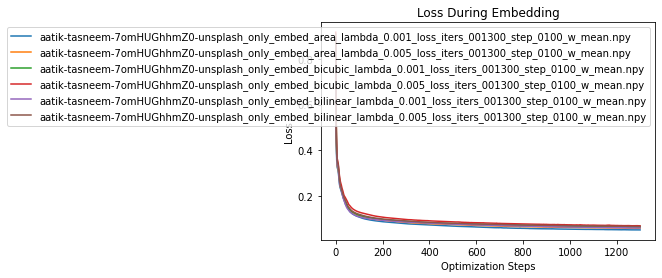

In [ ]:
# plot losses
plot_loss(losses, basename = "losses_per_image",save = True)

In [43]:
latents_files = sorted(os.listdir(SAVING_DIR + "/latents"))
latents_files = {idx: f for idx, f in enumerate(latents_files) if ".npz" in f}
latents_files

{0: 'aatik-tasneem-7omHUGhhmZ0-unsplash_only_embed_area_lambda_0.001_latents_iters_001300_step_0100_w_mean.npz',
 1: 'aatik-tasneem-7omHUGhhmZ0-unsplash_only_embed_area_lambda_0.005_latents_iters_001300_step_0100_w_mean.npz',
 2: 'aatik-tasneem-7omHUGhhmZ0-unsplash_only_embed_bicubic_lambda_0.001_latents_iters_001300_step_0100_w_mean.npz',
 3: 'aatik-tasneem-7omHUGhhmZ0-unsplash_only_embed_bicubic_lambda_0.005_latents_iters_001300_step_0100_w_mean.npz',
 4: 'aatik-tasneem-7omHUGhhmZ0-unsplash_only_embed_bilinear_lambda_0.001_latents_iters_001300_step_0100_w_mean.npz',
 5: 'aatik-tasneem-7omHUGhhmZ0-unsplash_only_embed_bilinear_lambda_0.005_latents_iters_001300_step_0100_w_mean.npz',
 6: 'aatik-tasneem-7omHUGhhmZ0-unsplash_only_lanczos_bicubic_lambda_0.001_latents_iters_001300_step_0100_w_mean.npz',
 7: 'aatik-tasneem-7omHUGhhmZ0-unsplash_only_lanczos_bicubic_lambda_0.005_latents_iters_001300_step_0100_w_mean.npz',
 8: 'aatik-tasneem-7omHUGhhmZ0-unsplash_only_lanczos_bilinear_lambda_0.0

Saving last image...


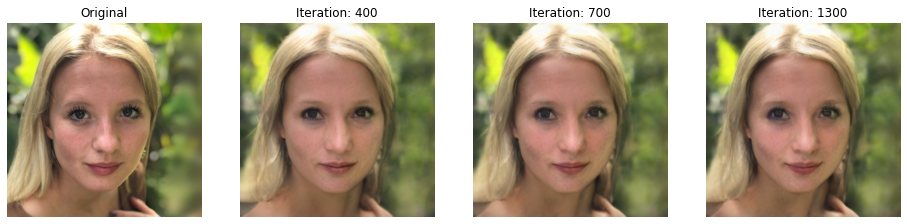

In [56]:
show_images_results(data, 3, latents_files[33], [400,700,1300],expected_result=False, save=False, save_last=True)

Saving last image...


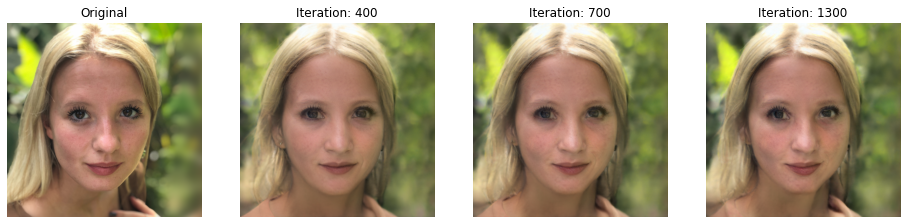

In [55]:
show_images_results(data, 3, latents_files[35], [400,700,1300],expected_result=False, save=False, save_last=True)

Saving last image...


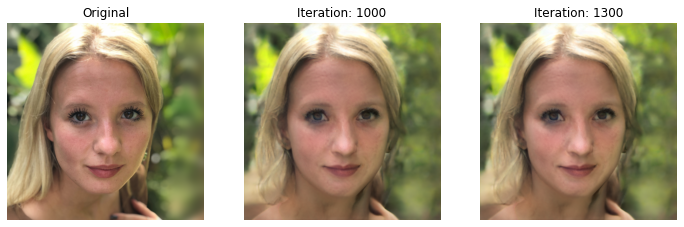

In [225]:
show_images_results(data, 3, latents_files[34], [1000,1300],expected_result=False, save=False, save_last=True)

Saving last image...


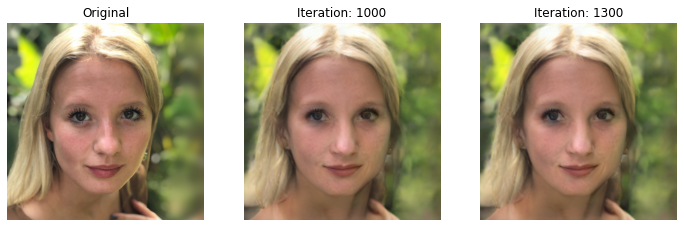

In [226]:
show_images_results(data, 3, latents_files[35], [1000,1300],expected_result=False, save=False, save_last=True)

In [ ]:
for i in range(71):
  show_images_results(data, 0, latents_files[i], [1300],expected_result=False, save=False, save_last=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for i in range(12):
  show_images_results(data, i, latents_files[i], [1300],expected_result=True, save=True, save_last=True)

Output hidden; open in https://colab.research.google.com to view.

# Plot Results of differente test

In [ ]:
def plot_folders(folders_results, subfix = "", save = False):


  references = load_data(PATH_DIR)
  expected_results = load_data(EXPECTED_RESULTS)

  experiments = []
  labels = []
  for label, path in folders_results.items():
    path = os.path.join(SAVING_DIR,path)
    experiments.append(load_data(path))
    labels.append(label)

  data2plot = [references] + experiments + [expected_results]
  labels = ["references"] + labels + ["expected"] 

  inches = 4
  rows = len(references)
  cols = len(experiments) + 2
  fig, axs = plt.subplots(rows, cols,figsize=(inches * cols , inches * rows))

  for j in range(cols):
    for i in range(rows):
      axs[i,j].imshow(data2plot[j][i]['img'])

      if i == 0:
        axs[i,j].set_title(labels[j])

      axs[i,j].axis('off')

  if save:
    file_dir = os.path.join(SAVING_DIR, "multiple_results{}.svg".format(
        subfix))
    print("Saving: {}".format(file_dir))
    plt.savefig(file_dir)

            

Saving: stuff/results/synthetic_images_regulizer_v2/multiple_results_downsampling_experiments.svg


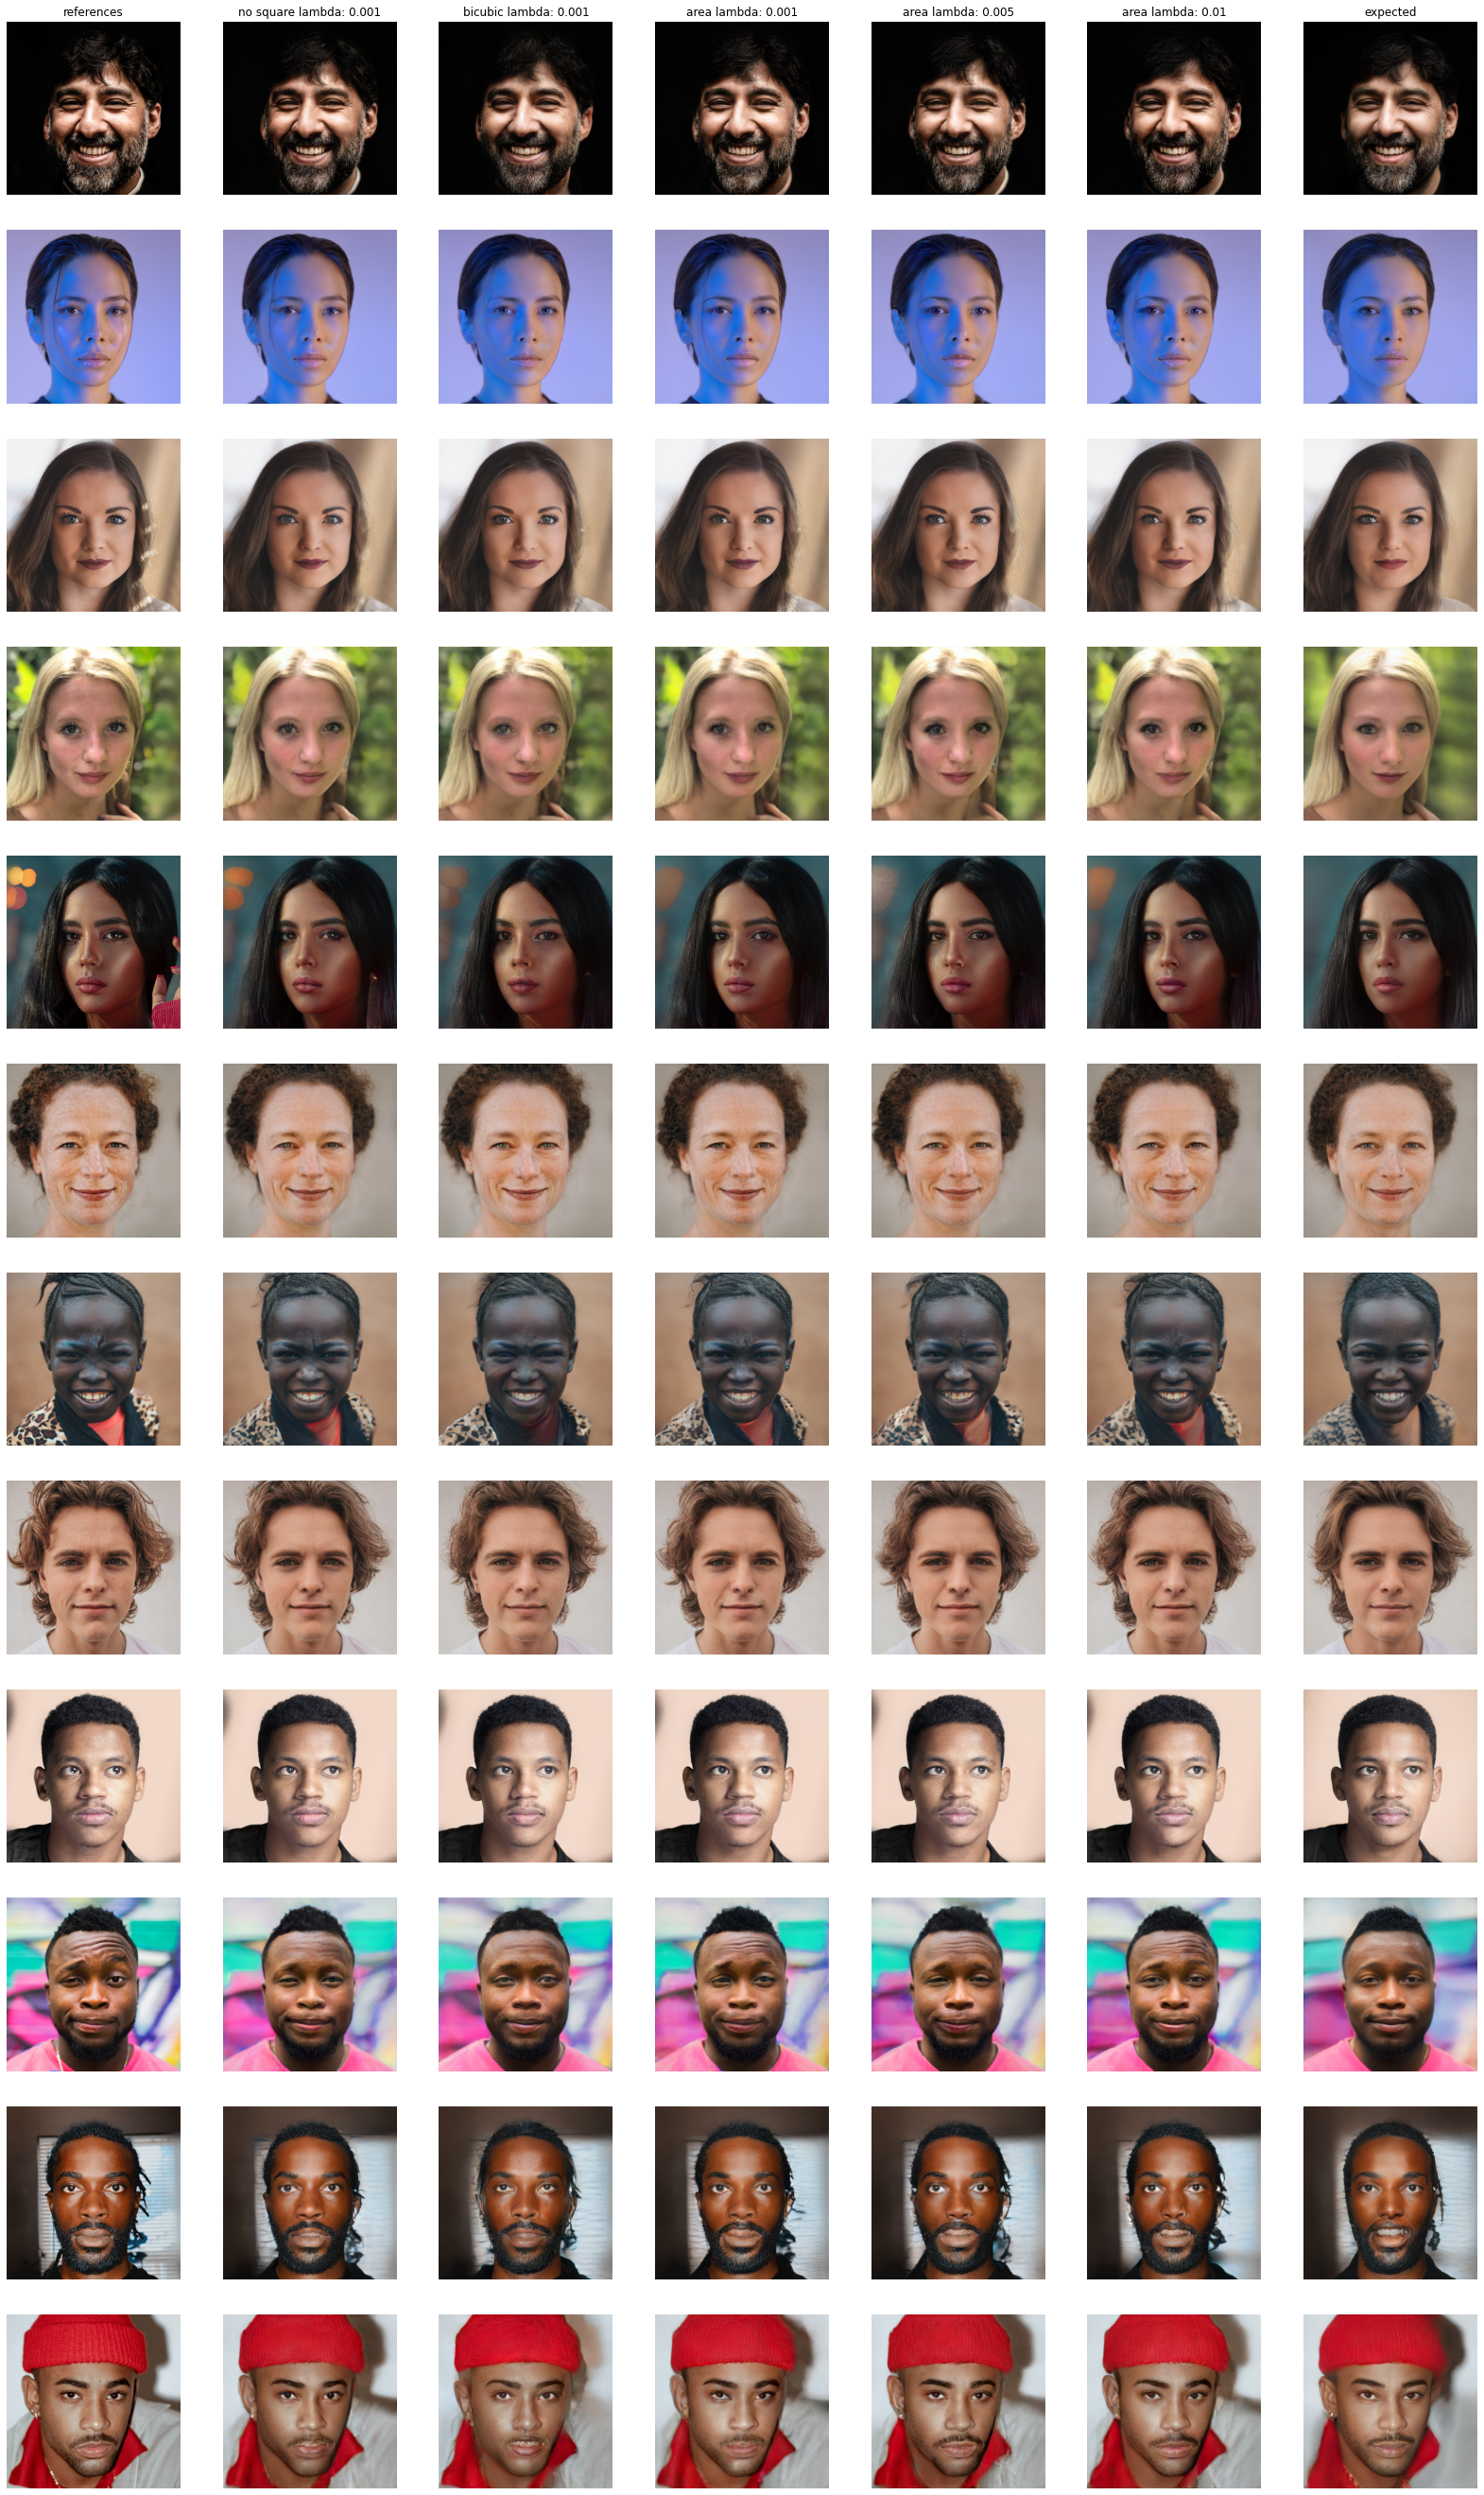

In [ ]:
plot_folders(folders_results, subfix = "_downsampling_experiments", save = True)